 <h1><center>Ising Model using Metropolis</center></h1>



### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Initial State ( all spins aligned or random )

In [3]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    if string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

### Total Energy

In [4]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

### Metropolis 

In [5]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

### Magnetization

In [6]:
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

### Temporal Series 

In [7]:
@jit(nopython=True,fastmath=True,nogil=True)
def temporalseries(T,config,iterations,iterations_fluc,fluctuations,J,n):

    temporal_series = np.zeros((fluctuations,n,n))
    mag_data = np.zeros(fluctuations)
    ene_data = np.zeros(fluctuations)
    beta = 1/T
    
    #thermal equilibrium
    for i in range(iterations):
        #if i % 1000000 == 0:
            #print(i/iterations)
        config = MC_met(config,beta, J)
        
    for z in range(fluctuations):
        
        for i in range(iterations_fluc):
            config = MC_met(config,beta,J)

        temporal_series[z] = config
        ene_data[z] = Total_Energy(config, J) 
        mag_data[z] = mag(config)  
        
    return temporal_series, ene_data, mag_data

### Setting the conditions

In [9]:
J = 1     # J
n = 200    # Lattice size
T = 2.3  # Temperature
iterations = (n*n)**2    # Iterations to thermal equilibrium 
fluctuations = 2000 #2000      # Quantity of fluctuations
iterations_fluc = n*n  # Iterations in one fluctuation

In [10]:
config = initial_state(n, "random")
model = temporalseries(T, config, iterations, iterations_fluc, fluctuations, J, n)

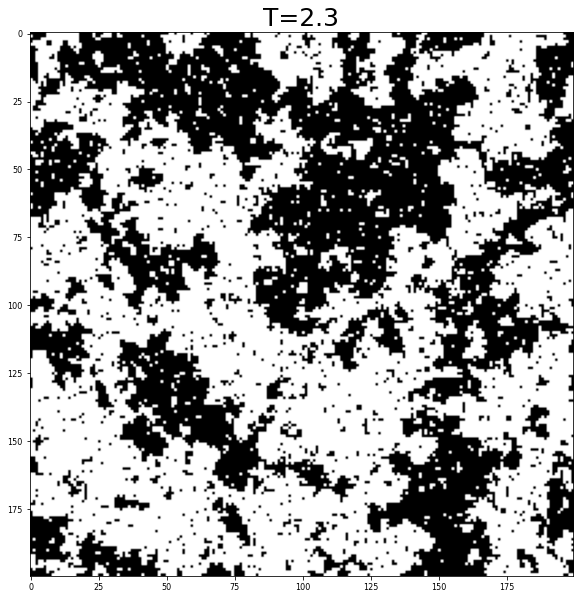

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(model[0][0], "Greys_r")
plt.title("T={}".format(T), fontsize=25)
#plt.savefig("T{}.png".format(T))
plt.show()


&nbsp;
# Results
&nbsp;
&nbsp;
&nbsp;


 <h2><center>Time consumption</center></h2>



 *  By an Asymptotic analysis, we aspect that the time consumption follows aproximatelly the number of iterations that we are doing. That's a good way to test the convergence of the algorithm.

**In this case i'm using ( N * N ) iterations. Hence, $$O(n^2)$$**

In [13]:
import matplotlib.pyplot as plt
from scipy.odr import *
import seaborn as sns
sns.color_palette("pastel")
sns.set_style("whitegrid")
plt.rc("axes", titlesize=20)
plt.rc("axes", labelsize=20)

In [9]:
time_con = np.loadtxt("time_consumption.txt")
N = np.loadtxt("time_consumption_N.txt")

In [10]:
def f(p,x):
    return p[0]*x**2 + p[1]*x + p[2]

# Create a model for fitting.
linear_model = Model(f)
# Create a RealData object using our initiated data from above.
data = RealData(N[1:], abs(time_con[1:]))
# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0.1, 1,1])
# Run the regression.
out = odr.run()
# Use the in-built pprint method to give us results.
out.pprint()

Beta: [3.61943011e-05 9.77672809e-04 5.12047995e-01]
Beta Std Error: [3.90572557e-07 1.70347758e-04 1.58507659e-02]
Beta Covariance: [[ 1.13726379e-10 -4.83311250e-08  3.76670505e-06]
 [-4.83311250e-08  2.16336900e-05 -1.83322074e-03]
 [ 3.76670505e-06 -1.83322074e-03  1.87308835e-01]]
Residual Variance: 0.0013413503861325492
Inverse Condition #: 3.5367157732703325e-05
Reason(s) for Halting:
  Sum of squares convergence


## $$ f(t) = w_1 t^2 + w_2 t + w_3 $$

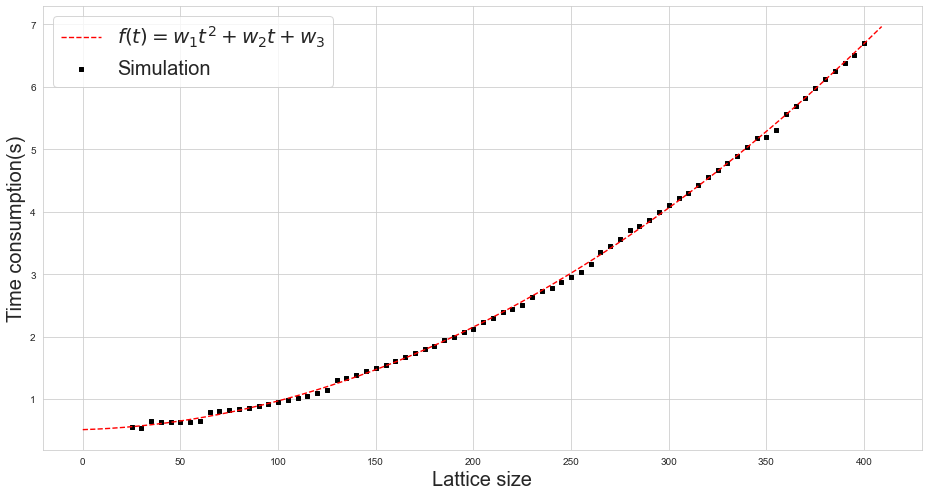

In [11]:
plt.figure(1,figsize=(13,7),tight_layout=True)
plt.scatter(N[1:],abs(time_con[1:]),marker=",",s=10,color="black",label="Simulation")
plt.plot(np.arange(410),f([3.61943011e-05, 9.77672809e-04, 5.12047995e-01],np.arange(410)),linewidth=1.4,color="red",
        label="$f(t) = w_1 t^2 + w_2 t + w_3 $",linestyle="dashed" )
plt.xlabel("Lattice size")
plt.ylabel("Time consumption(s)")
plt.legend(prop={'size' : 20})
plt.show()

## - Energy and magnetization by temperature

<h2><center>In the literature</center></h2>

<center><img src="Average-of-absolute-magnetization-of-the-2-D-Ising-model-with-periodic-boundary.png" width=500 height=500 /><center>

reference: https://www.researchgate.net/publication/269873176_Thermodynamics_of_the_2-D_Ising_Model_From_a_Random_Path_Sampling_Method

<center><img src="Screen Shot 2021-06-18 at 10.16.40.png" width=500 height=500 /><center>

reference: https://cds.cern.ch/record/2280218/files/cern-summer-student.pdf

<h2><center>My results</center></h2>



### Magnetization

In [11]:
T_1 = np.linspace(1.5,2.1,10)
T_2 = np.linspace(2.106,2.7,80)
T_3 = np.linspace(2.706,4,30)
T = np.hstack((T_1,T_2,T_3 )).ravel()
n = 200
mag_data = np.loadtxt("mag_data(n=200).txt")

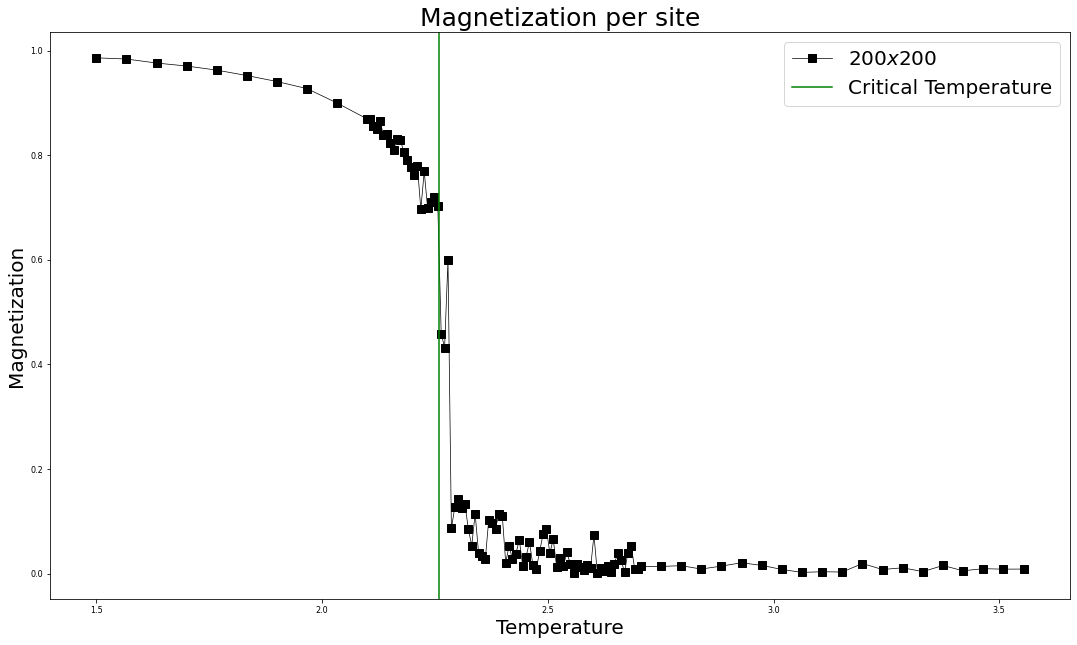

In [34]:
plt.figure(2,figsize=(15,9),tight_layout=True)
plt.plot(T[:110], abs(mag_data/(n*n))[:110], color="black", marker="s",label=r"$200x200$", linewidth=0.7,markersize=7.5)
plt.title("Magnetization per site",fontsize=25)
plt.axvline(2.26, color="green", label="Critical Temperature")
plt.legend(prop={'size' : 20})
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.savefig("Magnetization_per_site.png")
plt.show()

## Energy

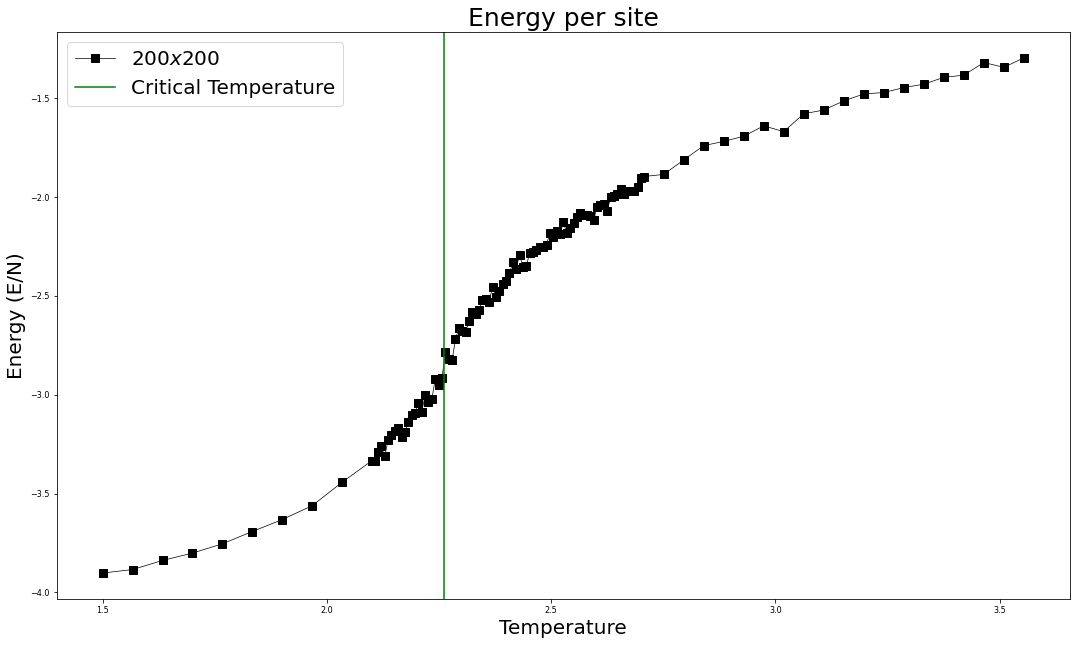

In [35]:
energy_data = np.loadtxt("energy_data(n=200).txt")
plt.figure(3,figsize=(15,9),tight_layout=True)
plt.plot(T[:110], (4*energy_data/(n*n))[:110], color="black", marker="s",label=r"$200x200$", linewidth=0.7,markersize=7.5)
plt.title("Energy per site",fontsize=25)
plt.axvline(2.26, color="green", label="Critical Temperature")
plt.legend(prop={'size' : 20})
plt.xlabel('Temperature')
plt.ylabel('Energy (E/N)')
plt.savefig("Energy_per_site.png")
plt.show()


&nbsp;
&nbsp;
&nbsp;



# The Drunk Walk  (Typical of stochastic process) 
&nbsp;
&nbsp;



&nbsp;
&nbsp;
&nbsp;
&nbsp;


* We are going to analyze the drunk walk of the magnetization and energy data near the critical temperature. But why in the critical temperature? Near the critical temperature we have more fluctuations because the finite simulation don't deal well in this scenario.

<h2><center>Magnetization</center></h2>



In [15]:
adb_mag = np.loadtxt("adb_mag(200).txt")
adb_mag = np.reshape(adb_mag,(200,10000))

In [16]:
mag_mean_dist = np.zeros(200)
for i in range(200):
    mag_mean_dist[i] = np.mean(adb_mag[i])
mean_dist_mag = np.mean(mag_mean_dist/(200*200))
st_dist_mag = np.std(mag_mean_dist/(200*200))
print("Mean", mean_dist_mag,"stdev",st_dist_mag)

Mean 0.0018702588749999998 stdev 0.03883897384702565


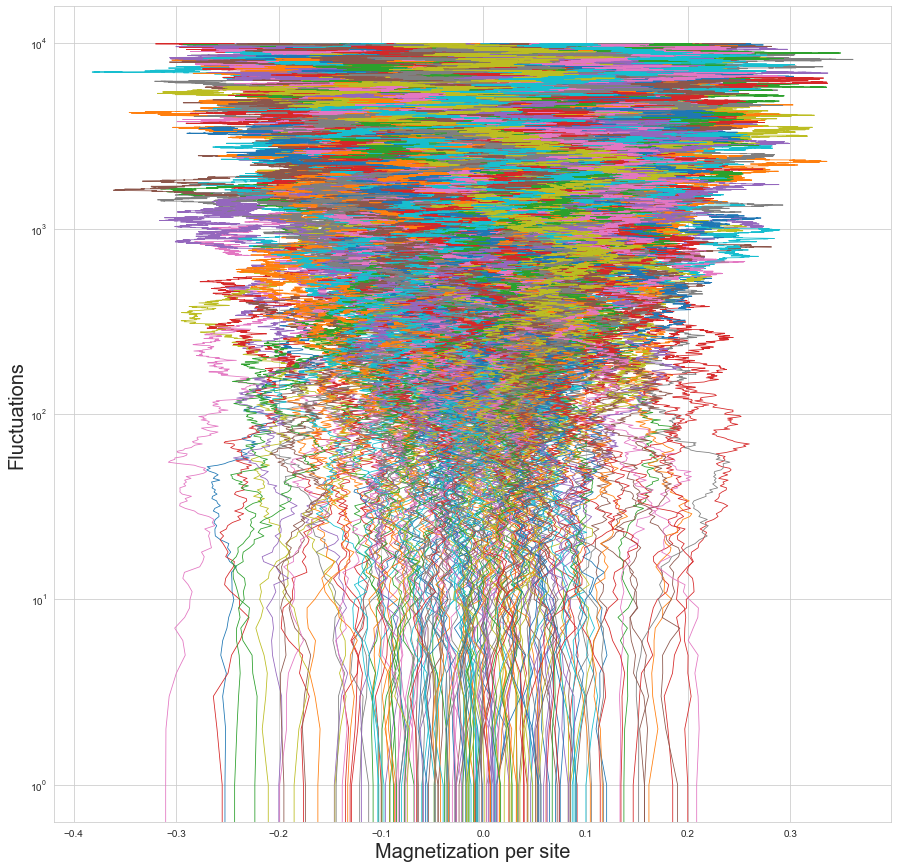

In [17]:
plt.figure(4,figsize=(15,15))
for i in range(200):
    plt.plot(adb_mag[i]/(200*200), np.arange(10000),linewidth=0.8)    
plt.ylabel("Fluctuations")
plt.yscale("log")
plt.xlabel("Magnetization per site")
plt.show()

### Mean distance

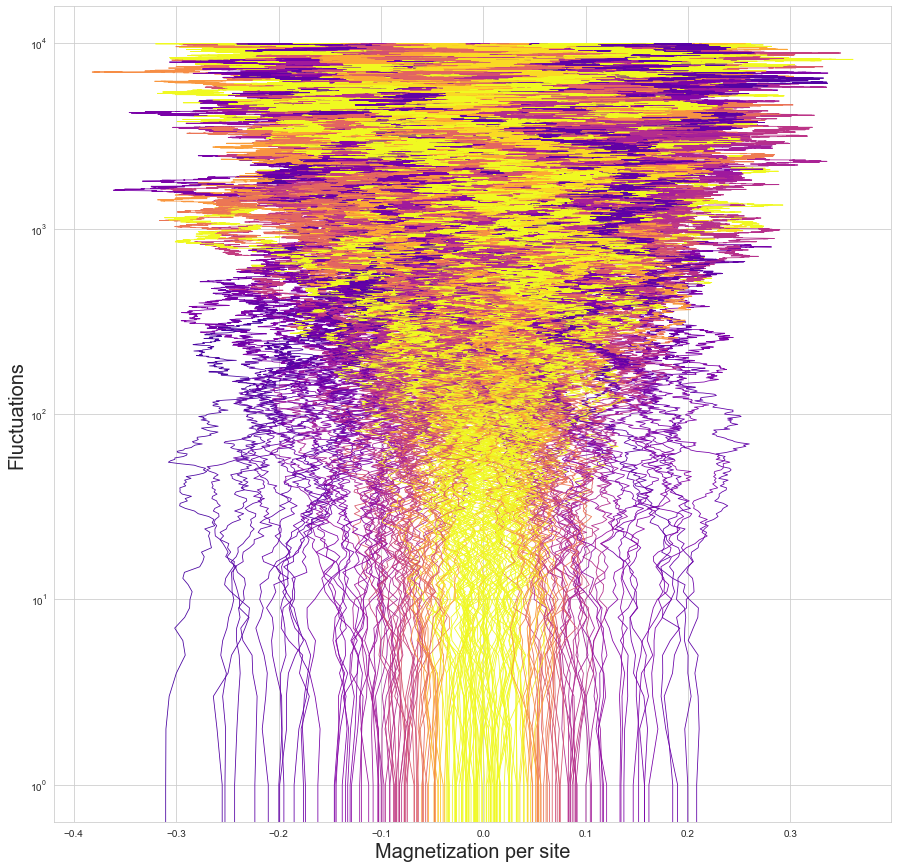

In [18]:
plt.figure(5,figsize=(15,15))
for i in range(200):
    plt.plot(adb_mag[i]/(200*200), np.arange(10000),linewidth=0.8,
             color=plt.cm.plasma((np.max(adb_mag/(200*200))/abs(abs(adb_mag[i][0]/(200*200)) - mean_dist_mag))/10))     
plt.ylabel("Fluctuations")
plt.yscale("log")
plt.xlabel("Magnetization per site")
plt.show()

### Closer to the mean

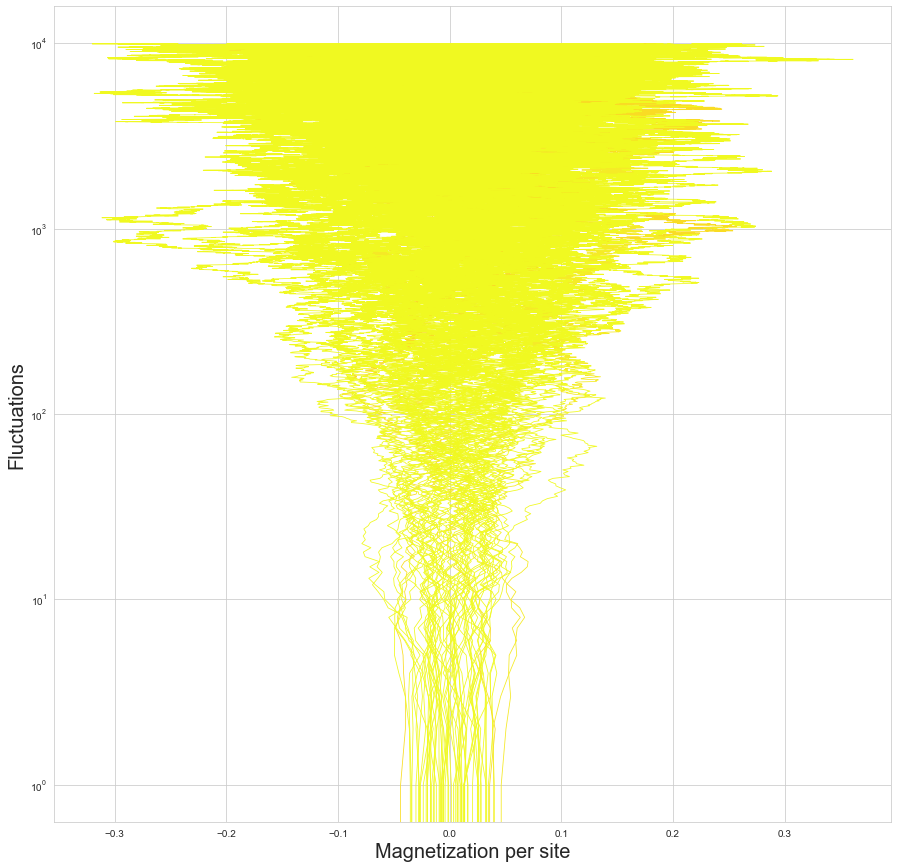

In [19]:
plt.figure(6,figsize=(15,15))
for i in range(150):
    if abs(abs(adb_mag[i][0]/(200*200)) - mean_dist_mag) < 0.04:
        plt.plot(adb_mag[i]/(200*200), np.arange(10000),linewidth=0.8,
             color=plt.cm.plasma((np.max(adb_mag/(200*200))/abs(abs(adb_mag[i][0]/(200*200)) - mean_dist_mag))/10))      
    
plt.ylabel("Fluctuations")
plt.yscale("log")
plt.xlabel("Magnetization per site")
plt.show()

### Far from the mean

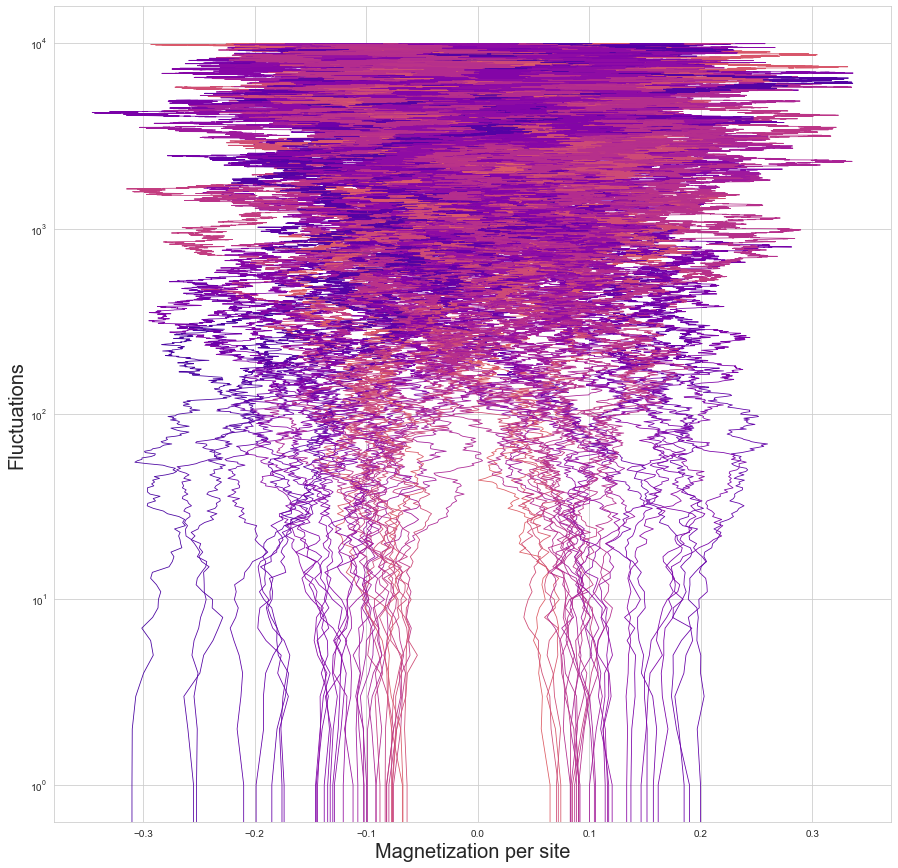

In [20]:
plt.figure(7,figsize=(15,15))
for i in range(150):
    if abs(abs(adb_mag[i][0]/(200*200)) - mean_dist_mag) > 0.06: #and (abs(adb_mag[i][0]/(200*200))) > 0.1:
        plt.plot(adb_mag[i]/(200*200), np.arange(10000),linewidth=0.8,
             color=plt.cm.plasma((np.max(adb_mag/(200*200))/abs(abs(adb_mag[i][0]/(200*200)) - mean_dist_mag))/10))      
    
plt.ylabel("Fluctuations")
plt.yscale("log")
plt.xlabel("Magnetization per site")
plt.show()

###  Distribution of the mean for each simulation

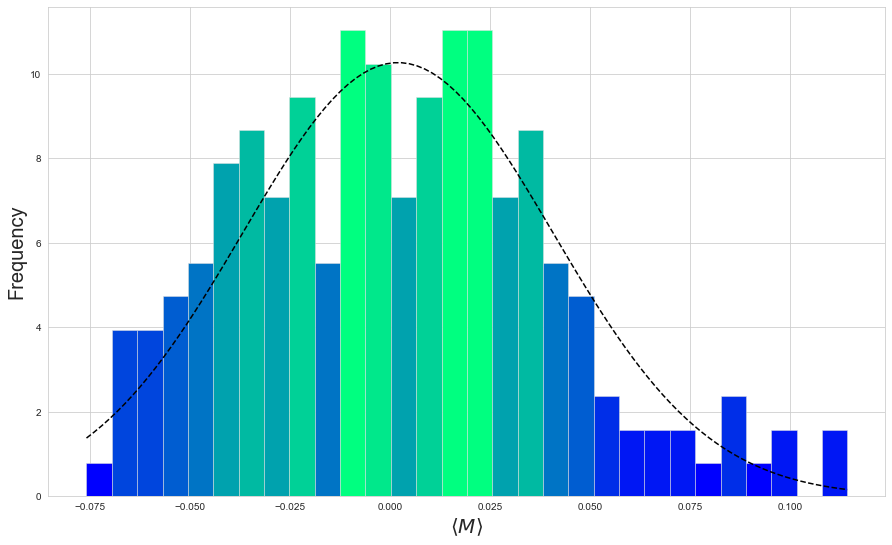

In [21]:
from scipy.stats import norm

plt.figure(8,figsize=(15,9))
bins = 30
n, bins, patches = plt.hist(mag_mean_dist/(200*200),bins=bins, density=True, facecolor='#2ab0ff',edgecolor='#e0e0e0',linewidth=0.5)

n = n.astype('int') # it MUST be integer

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.winter(n[i]/max(n)))
    
plt.xlabel(r"$\langle M \rangle$")
plt.ylabel("Frequency")
x = np.linspace(np.min(mag_mean_dist/(200*200)),np.max(mag_mean_dist/(200*200)), 100)

plt.plot(x, norm.pdf(x, mean_dist_mag,st_dist_mag),color='black', linestyle='dashed')
plt.show()




<h2><center>Energy</center></h2>



In [22]:
adb_ene = np.loadtxt("adb_ene(200).txt")
adb_ene = np.reshape(adb_ene, (200,10000))

In [23]:
ene_mean_dist = np.zeros(200)
for i in range(200):
    ene_mean_dist[i] = np.mean(adb_ene[i])

mean_dist_ene = np.mean(ene_mean_dist/(200*200))
st_dist_ene = np.std(ene_mean_dist/(200*200))
print("Mean", mean_dist_ene,"stdev",st_dist_ene)

Mean -0.6326876246750001 stdev 0.0006840991869104394


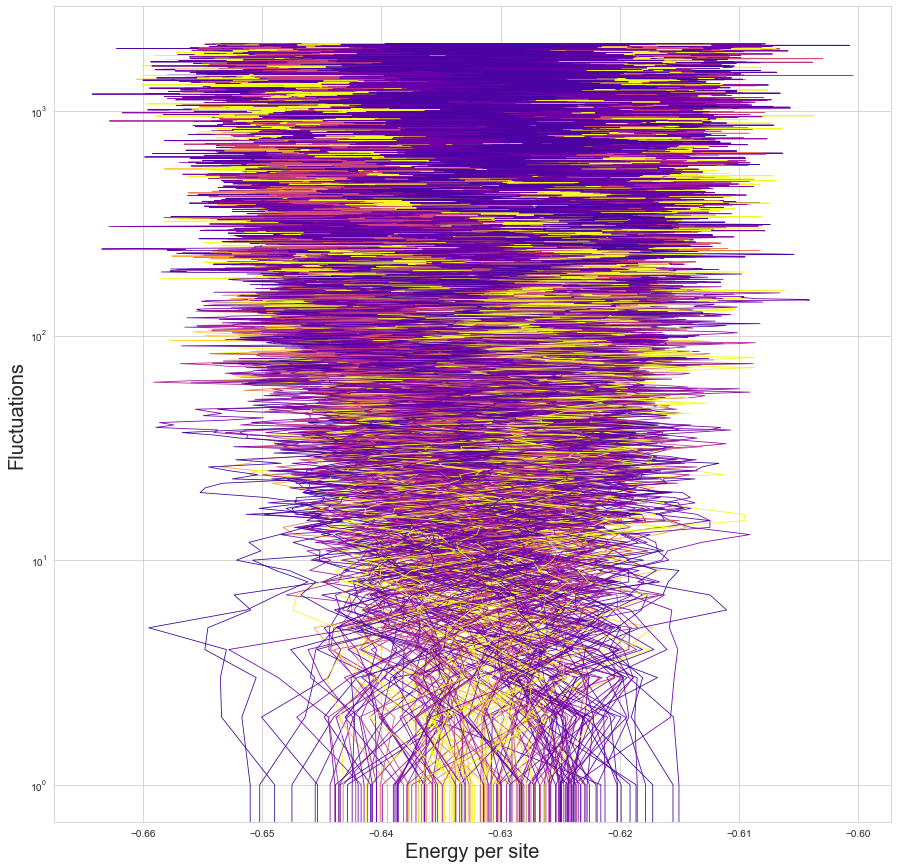

In [24]:
plt.figure(9,figsize=(15,15))
for i in range(200):
    plt.plot(adb_ene[i][:2000]/(200*200), np.arange(2000),linewidth=0.8,
             color=plt.cm.plasma(-(adb_ene[i][0]/(200*200))/abs(-adb_ene[i][0]/(200*200) + mean_dist_ene)/400))
    #print(-(adb_ene[i][0]/(200*200))/abs(-adb_ene[i][0]/(200*200) - 0.635)/1000)
plt.ylabel("Fluctuations")
plt.yscale("log")
plt.xlabel("Energy per site")
plt.show()

### Distribution of the Mean of each simulation

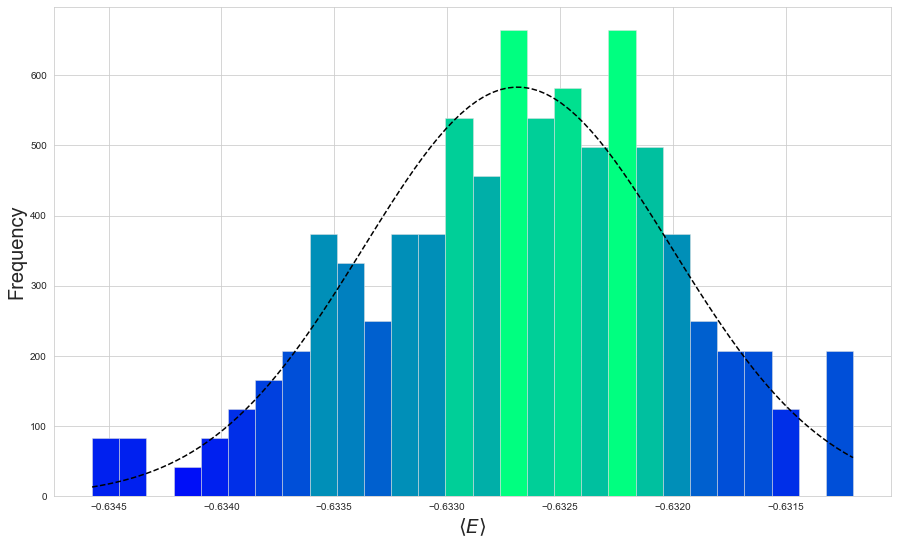

In [25]:
from scipy.stats import norm

plt.figure(10,figsize=(15,9))
bins = 28
n, bins, patches = plt.hist(ene_mean_dist/(200*200),bins=bins, density=True, facecolor='#2ab0ff',edgecolor='#e0e0e0',linewidth=0.5)

n = n.astype('int') # it MUST be integer

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.winter(n[i]/max(n)))

    
plt.xlabel(r"$\langle E \rangle$")
plt.ylabel("Frequency")
x = np.linspace(np.min(ene_mean_dist/(200*200)),np.max(ene_mean_dist/(200*200)), 100)

plt.plot(x, norm.pdf(x, mean_dist_ene,st_dist_ene),color='black', linestyle='dashed')
plt.show()


